<h3>Load helper functions</h3>

In [2]:
%run _utils.ipynb

<h3>Load Greenkeeper In-Range Breaking Build <code>issues</code></h3>

In [7]:
issues = load_issues()
comments = load_comments()

<h3>Load <code>all_issues</code></h3>
<p>NOTE that this includes every single issue from every single repo in the list of repos from the GK In-range breaking build issues set</p>

Count=2398438 (Project Count=12017) Median=55.0 Mean=199.58708496296913


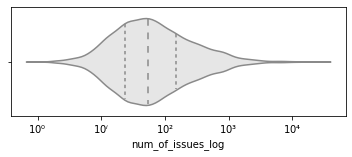

In [4]:
all_issues = load_all_issues()
counts = all_issues.groupby('repo_name')['id'].count()
print(f"Count={len(all_issues)} (Project Count={len(counts)}) Median={counts.median()} Mean={counts.mean()}")
for_plot = counts.to_frame(name='num_of_issues')
for_plot['placeholder'] = ''
for_plot['num_of_issues_log'] = np.log10(for_plot['num_of_issues'])
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6,2))
ax = sns.violinplot(
    data=for_plot,
    x='num_of_issues_log',
    y='placeholder',
    inner='quartile',
    palette=['0.9'],
    logscale=True
)
ax.set_ylabel('')
ax.xaxis.set_major_formatter(log10_func_formatter)
plt.show()

<h3>Create data sets of <code>non_gk_issues</code> and <code>gk_issues</code></h3>
<p>
    For analysis, we ignore gk_issues that we dont have all issues for, and remove the duplicate gk_issues from the all_issues data set
</p>

In [5]:
def filter_issues_for_analyses(all_issues, gk_issues):
    # Make copies
    gk_issues_for_analysis = gk_issues.copy()
    non_gk_issues_for_analysis = all_issues.copy()
    # Remove pull requests from all issues
    non_gk_issues_for_analysis = non_gk_issues_for_analysis[
        ~non_gk_issues_for_analysis['is_pull_request']
    ]
    # Filter out any issues that are GK in-range breakin gbuild issues
    non_gk_issues_for_analysis = non_gk_issues_for_analysis[
        ~non_gk_issues_for_analysis['id'].isin(gk_issues_for_analysis['id'])
    ]
    # Only analyze GK issues for projects we have all issues for
    gk_issues_for_analysis = gk_issues_for_analysis[
        gk_issues_for_analysis['repo_name'].isin(non_gk_issues_for_analysis['repo_name'])
    ]
    # Copy the html_url and body attributes over from all_issues to their respective rows on gk_issues
    gk_issues_for_analysis = gk_issues_for_analysis.merge(
        all_issues[['id', 'html_url', 'body']],
        how='left',
        on='id',
    )
    return non_gk_issues_for_analysis, gk_issues_for_analysis
    

non_gk_issues, gk_issues = filter_issues_for_analyses(all_issues, issues)

<h2><b>Pinning</b></h2>

<h3><b><i>How successful is auto-pinning the dependency?</i></b></h3>

In [9]:
pinning_comments = comments.loc[
    (
        (comments['comment_user_type'] == 'Bot') &
        (comments['comment_user_login'] == 'greenkeeper[bot]') &
        (comments['comment_body'].str.contains('After pinning to', case=False))
    )
][['comment_issue_id', 'comment_url', 'comment_body']]
issue_pin_status = pinning_comments.merge(
    gk_issues[['id', 'url', 'title', 'html_url', 'body']],
    left_on='comment_issue_id',
    right_on='id'
)
# Re-order columns
issue_pin_status = issue_pin_status[['id', 'url', 'title', 'html_url', 'body', 'comment_issue_id', 'comment_url', 'comment_body']]
issue_pin_status['pin_status'] = 'unknown'
pin_fail_regex = '|'.join([
    "your tests are still failing",
])
pin_success_regex = '|'.join([
    "your tests are passing again"
])
issue_pin_status.loc[
    issue_pin_status['comment_body'].str.contains(pin_success_regex, case=False),
    'pin_status'
] = 'success'
issue_pin_status.loc[
    issue_pin_status['comment_body'].str.contains(pin_fail_regex, case=False),
    'pin_status'
] = 'failure'

issue_pin_status['pin_status'].value_counts()

proportions = (
    issue_pin_status['pin_status'].value_counts() / 
    issue_pin_status['pin_status'].count()
).to_frame(name='proportion')\
    .rename_axis('pin_status')\
    .reset_index()
print('--How successful is pinning the dependency?--')
proportions.head()

--How successful is pinning the dependency?--


,pin_status,proportion
0,failure,0.676202
1,success,0.323798


<h4>Write out cases for manual analysis</h4>

In [10]:
# failed_pins = issue_pin_status[issue_pin_status['pin_status'] == 'failure']
# # failed_pins.info()
# sample_failed_pins = failed_pins.sample(n=800, random_state=42)
# sample_failed_pins.to_csv(f'./manual_analysis/failed_pins/sample_failed_pins.csv', index=False)

<h4>Do success/fail pins predict whether a new release will fix the issue?</h4>

In [13]:
succ_pin_issue_ids = issue_pin_status[issue_pin_status['pin_status'] == 'success']['id'].unique()
fail_pin_issues_ids = issue_pin_status[issue_pin_status['pin_status'] == 'failure']['id'].unique()

gk_comments = comments.loc[
    (
        (comments['comment_user_type'] == 'Bot') &
        (comments['comment_user_login'] == 'greenkeeper[bot]')
    )
]
# Get comments for issues with successful pins
succ_pin_gk_comments = gk_comments[gk_comments['comment_issue_id'].isin(succ_pin_issue_ids)]

failing_with_new_release_regex = 'Your tests are still failing with this version'
passing_with_new_release_regex = 'Your tests are passing again with this version'


def comment_group_saw_new_release(comment_group):
    new_release_comments = comment_group[
        (comment_group['comment_body'].str.contains(failing_with_new_release_regex)) |
        (comment_group['comment_body'].str.contains(passing_with_new_release_regex))
    ]
    return len(new_release_comments) > 0

def issue_has_passing_with_new_release_comment(comment_group):
    new_passing_release_comments = comment_group[
        comment_group['comment_body'].str.contains(passing_with_new_release_regex)
    ]
    return len(new_passing_release_comments) > 0

def issue_has_failing_with_new_release_comment(comment_group):
    new_failing_release_comments = comment_group[
        comment_group['comment_body'].str.contains(failing_with_new_release_regex)
    ]
    return len(new_failing_release_comments) > 0

def issue_has_only_failing_new_release_comments(comment_group):
    return (
        not issue_has_passing_with_new_release_comment(comment_group) and
        issue_has_failing_with_new_release_comment(comment_group)
    )

def issue_has_only_passing_new_release_comments(comment_group):
    return (
        issue_has_passing_with_new_release_comment(comment_group) and
        not issue_has_failing_with_new_release_comment(comment_group)
    )

print('SUCCESSFUL PINS')

# Only issues that saw new release
succ_pin_comments_with_new_release = \
    succ_pin_gk_comments\
        .groupby('comment_issue_id')\
        .filter(comment_group_saw_new_release)

succ_pin_comments_with_new_release_count = (
    succ_pin_comments_with_new_release['comment_issue_id']
        .nunique()
)

passing_with_new_release = (
    succ_pin_comments_with_new_release
        .groupby('comment_issue_id')
        .filter(issue_has_passing_with_new_release_comment)
)
issues_with_passing_new_release_count = (
    passing_with_new_release['comment_issue_id']
        .nunique()
)
proportion = calculate_percent(
    issues_with_passing_new_release_count,
    succ_pin_comments_with_new_release_count
)
print(f'{proportion}% ({issues_with_passing_new_release_count}/{succ_pin_comments_with_new_release_count}) \
of issues with a successful pin attempt also eventually see a new passing release of the dependency')

only_failing_new_release = (
    succ_pin_comments_with_new_release
        .groupby('comment_issue_id')
        .filter(issue_has_only_failing_new_release_comments)
)
issues_with_only_failing_new_release_count = (
    only_failing_new_release['comment_issue_id']
        .nunique()
)
proportion = calculate_percent(
    issues_with_only_failing_new_release_count,
    succ_pin_comments_with_new_release_count
)
print(f'''\
{proportion}% ({issues_with_only_failing_new_release_count}/{succ_pin_comments_with_new_release_count}) \
of issues with a successful pin attempt only see new failing releases of the dependency'
(i.e. none of the dependencies new releases ever pass the clients pipeline )
''')

only_passing_new_release = (
    succ_pin_comments_with_new_release
        .groupby('comment_issue_id')
        .filter(issue_has_only_passing_new_release_comments)
)
issues_with_only_passing_new_release_count = (
    only_passing_new_release['comment_issue_id']
        .nunique()
)
proportion = calculate_percent(
    issues_with_only_passing_new_release_count,
    succ_pin_comments_with_new_release_count
)
print(f'''\
{proportion}% ({issues_with_only_passing_new_release_count}/{succ_pin_comments_with_new_release_count}) \
of issues with a successful pin attempt only see new passing releases of the dependency'
(i.e. all of the dependencies new releases pass the clients pipeline )
''')

SUCCESSFUL PINS
38.1% (2980/7822) of issues with a successful pin attempt also eventually see a new passing release of the dependency
61.9% (4842/7822) of issues with a successful pin attempt only see new failing releases of the dependency'
(i.e. none of the dependencies new releases ever pass the clients pipeline )

26.51% (2074/7822) of issues with a successful pin attempt only see new passing releases of the dependency'
(i.e. all of the dependencies new releases pass the clients pipeline )



In [15]:
# Only issues that saw new release
succ_pin_comments_with_new_release = \
    succ_pin_gk_comments\
        .groupby('comment_issue_id')\
        .filter(comment_group_saw_new_release)

succ_pin_comments_with_new_release_count = (
    succ_pin_comments_with_new_release['comment_issue_id']
        .nunique()
)


only_failing_new_release = (
    succ_pin_comments_with_new_release
        .groupby('comment_issue_id')
        .filter(issue_has_only_failing_new_release_comments)
)
issues_with_only_failing_new_release_count = (
    only_failing_new_release['comment_issue_id']
        .nunique()
)
proportion = calculate_percent(
    issues_with_only_failing_new_release_count,
    succ_pin_comments_with_new_release_count
)
print(f'''\
{proportion}% ({issues_with_only_failing_new_release_count}/{succ_pin_comments_with_new_release_count}) \
of issues with a successful pin attempt only see new failing releases of the dependency'
(i.e. none of the dependencies new releases ever pass the clients pipeline )
''')

only_passing_new_release = (
    succ_pin_comments_with_new_release
        .groupby('comment_issue_id')
        .filter(issue_has_only_passing_new_release_comments)
)
issues_with_only_passing_new_release_count = (
    only_passing_new_release['comment_issue_id']
        .nunique()
)
proportion = calculate_percent(
    issues_with_only_passing_new_release_count,
    succ_pin_comments_with_new_release_count
)
print(f'''\
{proportion}% ({issues_with_only_passing_new_release_count}/{succ_pin_comments_with_new_release_count}) \
of issues with a successful pin attempt only see new passing releases of the dependency'
(i.e. all of the dependencies new releases pass the clients pipeline )
''')



61.9% (4842/7822) of issues with a successful pin attempt only see new failing releases of the dependency'
(i.e. none of the dependencies new releases ever pass the clients pipeline )

26.51% (2074/7822) of issues with a successful pin attempt only see new passing releases of the dependency'
(i.e. all of the dependencies new releases pass the clients pipeline )



In [12]:
print('FAIL PINS')

fail_pin_gk_comments = gk_comments[gk_comments['comment_issue_id'].isin(fail_pin_issues_ids)]

fail_pin_comments_with_new_release = (
    fail_pin_gk_comments
        .groupby('comment_issue_id')
        .filter(comment_group_saw_new_release)
)

fail_pin_comments_with_new_release_count = (
    fail_pin_comments_with_new_release['comment_issue_id']
        .nunique()
)

passing_with_new_release = (
    fail_pin_comments_with_new_release
        .groupby('comment_issue_id')
        .filter(issue_has_passing_with_new_release_comment)
)
issues_with_passing_new_release_count = (
    passing_with_new_release['comment_issue_id']
        .nunique()
)
proportion = calculate_percent(
    issues_with_passing_new_release_count,
    fail_pin_comments_with_new_release_count
)
print(f'{proportion}% ({issues_with_passing_new_release_count}/{fail_pin_comments_with_new_release_count}) \
of issues with a failing pin attempt also eventually see a new passing release of the dependency')

only_failing_new_release = (
    fail_pin_comments_with_new_release
        .groupby('comment_issue_id')
        .filter(issue_has_only_failing_new_release_comments)
)
issues_with_only_failing_new_release_count = (
    only_failing_new_release['comment_issue_id']
        .nunique()
)
proportion = calculate_percent(
    issues_with_only_failing_new_release_count,
    fail_pin_comments_with_new_release_count
)
print(f'''\
{proportion}% ({issues_with_only_failing_new_release_count}/{fail_pin_comments_with_new_release_count}) \
of issues with a failing pin attempt only see new failing releases of the dependency'
(i.e. none of the dependencies new releases ever pass the clients pipeline )
''')

only_passing_new_release = (
    fail_pin_comments_with_new_release
        .groupby('comment_issue_id')
        .filter(issue_has_only_passing_new_release_comments)
)
issues_with_only_passing_new_release_count = (
    only_passing_new_release['comment_issue_id']
        .nunique()
)
proportion = calculate_percent(
    issues_with_only_passing_new_release_count,
    fail_pin_comments_with_new_release_count
)
print(f'''\
{proportion}% ({issues_with_only_passing_new_release_count}/{fail_pin_comments_with_new_release_count}) \
of issues with a failing pin attempt only see new passing releases of the dependency'
(i.e. all of the dependencies new releases pass the clients pipeline )
''')

FAIL PINS
8.83% (1757/19909) of issues with a failing pin attempt also eventually see a new passing release of the dependency
91.17% (18152/19909) of issues with a failing pin attempt only see new failing releases of the dependency'
(i.e. none of the dependencies new releases ever pass the clients pipeline )

4.62% (920/19909) of issues with a failing pin attempt only see new failing releases of the dependency'
(i.e. none of the dependencies new releases ever pass the clients pipeline )

